#   Derin √ñƒürenme Bootcamp Projesi : Intel Image Classification Veriseti ile

#  1) K√ºt√ºphanelerin Y√ºklenmesi ve Veri Setinin Tanƒ±mlanmasƒ±


* TensorFlow, NumPy, Matplotlib gibi temel k√ºt√ºphaneler y√ºklenmi≈ütir.
* Kaggle ortamƒ±nda bulunan **Intel Image Classification** veri setinin eƒüitim ve test dizinleri tanƒ±mlanmƒ±≈ütƒ±r.
* Veri setinin sƒ±nƒ±flarƒ± yazdƒ±rƒ±lmƒ±≈ütƒ±r. Veri seti , 6 sƒ±nƒ±ftan olu≈ümaktadƒ±r: **Buildings, Forest, Glacier, Mountain, Sea, Street**.  


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam

train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'


print("=== Veri Seti Hakkƒ±nda ===")

class_names = os.listdir(train_dir)
print(f"Sƒ±nƒ±f sayƒ±sƒ±: {len(class_names)}")
print("Sƒ±nƒ±flar:", class_names)

2025-09-26 17:21:47.203631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758907307.570559      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758907307.665527      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


=== Veri Seti Hakkƒ±nda ===
Sƒ±nƒ±f sayƒ±sƒ±: 6
Sƒ±nƒ±flar: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


# 2.1) Veri √ñn ƒ∞≈üleme 

Bu b√∂l√ºmde veri seti CNN modeline uygun hale getirilmi≈ütir:
 
* **Normalize edilerek (0‚Äì1 aralƒ±ƒüƒ±na)** piksel deƒüerleri √∂l√ßeklendirildi.

* Modelin a≈üƒ±rƒ± √∂ƒürenme ya≈üamamasƒ± i√ßin ve daha genelleyici hale gelmesi i√ßin eƒüitim verisi **Veri artƒ±rma**(Data augmentation) ile √ße≈üitlendirildi. (G√∂rseller d√∂nd√ºr√ºld√º,yatay ve dikey eksende kaydƒ±rƒ±ldƒ±,yakƒ±nla≈ütƒ±rma uzakla≈ütƒ±rma yapƒ±ldƒ±. )

* T√ºm g√∂r√ºnt√ºler 150x150 piksel boyutuna d√∂n√º≈üt√ºr√ºld√º.

* Batch sze belirlendi. Model bir defada  32 resim i≈üleyecek.B√∂ylece daha yava≈ü da olsa iyi bir eƒüitim yapacak.
* Eƒüitim verisinin %20‚Äôsi **validation seti** olarak ayrƒ±ldƒ±.  
* Test verisi yalnƒ±zca normalize edilerek modele hazƒ±rlandƒ±.  




In [2]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   validation_split=0.2)      

test_datagen = ImageDataGenerator(rescale=1./255)                             


train_generator = train_datagen.flow_from_directory(
    train_dir,                  
    target_size=(150, 150),      
    batch_size=32,                
    class_mode='categorical',     
    subset='training'           
)

# Validation verisini y√ºkleyelim.

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'                                                
)

# Test verisini y√ºkleyelim.

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False              
)

# 5. Y√ºklenen veriyi kontrol etme

print("=== VERƒ∞ SETƒ∞ Bƒ∞LGƒ∞LERƒ∞ ===")
print(f"Sƒ±nƒ±f isimleri: {list(train_generator.class_indices.keys())}")
print(f"Sƒ±nƒ±f sayƒ±sƒ±: {train_generator.num_classes}")
print(f"Eƒüitim √∂rnek sayƒ±sƒ±: {train_generator.samples}")
print(f"Validation √∂rnek sayƒ±sƒ±: {validation_generator.samples}")
print(f"Test √∂rnek sayƒ±sƒ±: {test_generator.samples}")


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
=== VERƒ∞ SETƒ∞ Bƒ∞LGƒ∞LERƒ∞ ===
Sƒ±nƒ±f isimleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Sƒ±nƒ±f sayƒ±sƒ±: 6
Eƒüitim √∂rnek sayƒ±sƒ±: 11230
Validation √∂rnek sayƒ±sƒ±: 2804
Test √∂rnek sayƒ±sƒ±: 3000


 # **2.2) Veri G√∂rselle≈ütirme**

* show_sample_images fonksiyonu, verilen veri √ºreticisinden (generator) bir batch resim ve etiket alƒ±p  ilk 16 resmi g√∂stermi≈ütir. Her resmin √ºst√ºnde sƒ±nƒ±f adƒ± yer almaktadƒ±r.
* Eƒüitim,validation,test olarak ayrƒ±lan verilerin ,sƒ±nƒ±f daƒüƒ±lƒ±mlarƒ± g√∂rselle≈ütirilmi≈ütir.

Eƒüitim verisinden √∂rnekler:


I0000 00:00:1758907332.385010      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758907332.385667      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


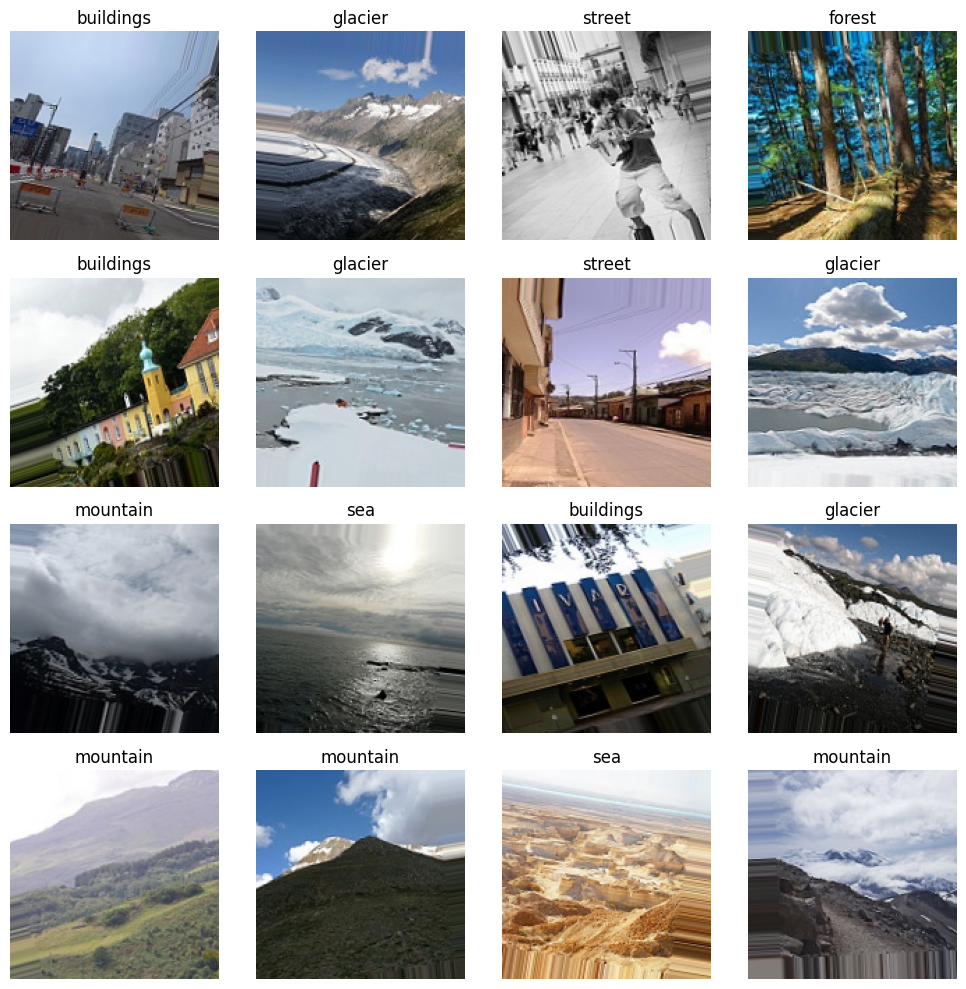

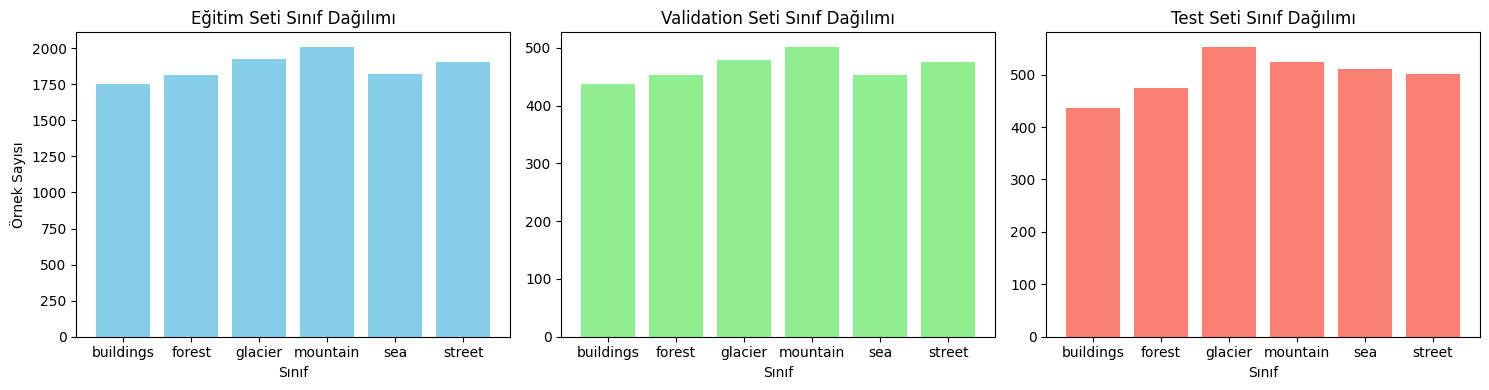

In [3]:
def show_sample_images(generator):
    images, labels = next(generator)                       
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(10,10))
    for i in range(16):                                     
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"{class_names[tf.argmax(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Eƒüitim verisinden √∂rnekler:")
show_sample_images(train_generator)

# Sƒ±nƒ±f daƒüƒ±lƒ±mlarƒ±nƒ± g√∂rselle≈ütirelim.

class_names = list(train_generator.class_indices.keys())

train_counts = train_generator.classes
val_counts   = validation_generator.classes
test_counts  = test_generator.classes

train_class_counts = [np.sum(train_counts == i) for i in range(len(class_names))]
val_class_counts   = [np.sum(val_counts == i)   for i in range(len(class_names))]
test_class_counts  = [np.sum(test_counts == i)  for i in range(len(class_names))]

fig, axes = plt.subplots(1, 3, figsize=(15,4))  


axes[0].bar(class_names, train_class_counts, color='skyblue')
axes[0].set_title('Eƒüitim Seti Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±')
axes[0].set_ylabel('√ñrnek Sayƒ±sƒ±')
axes[0].set_xlabel('Sƒ±nƒ±f')


axes[1].bar(class_names, val_class_counts, color='lightgreen')
axes[1].set_title('Validation Seti Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±')
axes[1].set_xlabel('Sƒ±nƒ±f')


axes[2].bar(class_names, test_class_counts, color='salmon')
axes[2].set_title('Test Seti Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±')
axes[2].set_xlabel('Sƒ±nƒ±f')

plt.tight_layout()  



* Verinin ; Eƒüitim , Validation , Test setlerine g√∂re ayrƒ±lma oranlarƒ± g√∂sterilmi≈ütir.

In [4]:
egitim = train_generator.samples
dogrulama = validation_generator.samples
test = test_generator.samples
toplam = egitim + dogrulama + test


egitim_yuzde = (egitim / toplam) * 100
dogrulama_yuzde = (dogrulama / toplam) * 100
test_yuzde = (test / toplam) * 100

print("Veri Daƒüƒ±lƒ±mƒ±:")
print(f"Eƒüitim: {egitim} (%{egitim_yuzde:.1f})")
print(f"Doƒürulama: {dogrulama} (%{dogrulama_yuzde:.1f})")
print(f"Test: {test} (%{test_yuzde:.1f})")

Veri Daƒüƒ±lƒ±mƒ±:
Eƒüitim: 11230 (%65.9)
Doƒürulama: 2804 (%16.5)
Test: 3000 (%17.6)


#  3) Modelin Eƒüitilmesi 

Model, CNN mimarisi kullanƒ±larak tasarlanmƒ±≈ütƒ±r.

Modelin yapƒ±sƒ± ≈ü√∂yledir:

* Conv2D + MaxPooling2D katmanlarƒ±: G√∂r√ºnt√ºlerden √∂znitelik √ßƒ±karmak i√ßin 3 adet evri≈üim ve havuzlama katmanƒ± eklenmi≈ütir. ƒ∞lk katman 32 filtre ile ba≈ülamakta, ardƒ±ndan 64 ve 128 filtreler ile derinlik artƒ±rƒ±lmaktadƒ±r.  
* Dropout katmanlarƒ±: A≈üƒ±rƒ± √∂ƒürenmeyi (overfitting) engellemek i√ßin %25 ve %50 oranƒ±nda dropout uygulanmƒ±≈ütƒ±r.
* Flatten + Dense katmanlarƒ±: Evri≈üim katmanlarƒ±ndan √ßƒ±kan √∂zellik haritalarƒ± d√ºzle≈ütirilmi≈ü ve 256 n√∂ronlu tam baƒülƒ± katmanla √∂ƒürenme yapƒ±lmƒ±≈ütƒ±r.  
* √áƒ±kƒ±≈ü katmanƒ± 6 sƒ±nƒ±f i√ßin softmax aktivasyonu kullanƒ±larak olasƒ±lƒ±k daƒüƒ±lƒ±mƒ± elde edilmi≈ütir.  
* Model Compile ile Derleme: Model adam optimizer ve categorical_crossentropy kayƒ±p fonksiyonu ile derlenmi≈ütir.  
* Model fit ile Eƒüitim: Model, train_generator ile eƒüitilmi≈ü ve validation_generator ile doƒürulanmƒ±≈ütƒ±r (10 epoch).  

Bu sayede model, verilen eƒüitim g√∂rsellerinden √∂ƒürenerek yeni g√∂rselleri doƒüru sƒ±nƒ±fa atamayƒ± ama√ßlamaktadƒ±r.


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 148, 148, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 74, 74, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 74, 74, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 72, 72, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 36, 36, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 36, 36, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 34, 34, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 17, 17, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 17, 17, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 36992)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ     9,470,208 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 9,564,998 (36.49 MB)

 Trainable params: 9,564,998 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1758907339.725779      83 service.cc:148] XLA service 0x7b394000e660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758907339.727329      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758907339.727369      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758907340.152767      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 54:33 9s/step - accuracy: 0.2500 - loss: 1.7744

I0000 00:00:1758907345.929870      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 138s 368ms/step - accuracy: 0.4196 - loss: 1.4996 - val_accuracy: 0.6138 - val_loss: 1.0102
Epoch 2/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 233ms/step - accuracy: 0.6295 - loss: 0.9678 - val_accuracy: 0.6944 - val_loss: 0.8657
Epoch 3/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 230ms/step - accuracy: 0.6720 - loss: 0.8749 - val_accuracy: 0.7343 - val_loss: 0.7345
Epoch 4/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 225ms/step - accuracy: 0.7105 - loss: 0.7836 - val_accuracy: 0.7707 - val_loss: 0.6674
Epoch 5/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 225ms/step - accuracy: 0.7376 - loss: 0.7260 - val_accuracy: 0.7653 - val_loss: 0.6947
Epoch 6/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 223ms/step - accuracy: 0.7550 - loss: 0.6974 - val_accuracy: 0.7767 - v

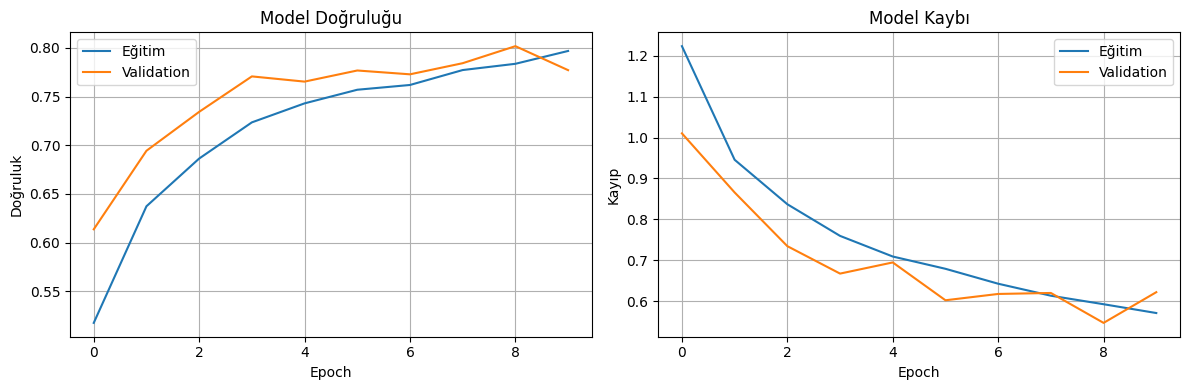

In [5]:
model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
        
# Tam baƒülƒ± katman
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer= Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)
plt.figure(figsize=(12, 4))  
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Eƒüitim') 
plt.plot(history.history['val_accuracy'], label='Validation') 
plt.title('Model Doƒüruluƒüu') 
plt.xlabel('Epoch')  
plt.ylabel('Doƒüruluk')  
plt.legend()  
plt.grid(True) 
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Eƒüitim') 
plt.plot(history.history['val_loss'], label='Validation')  
plt.title('Model Kaybƒ±') 
plt.xlabel('Epoch') 
plt.ylabel('Kayƒ±p') 
plt.legend()  
plt.grid(True) 
plt.tight_layout()  
plt.show()  


* Modelin, eƒüitim ve doƒürulama (validation) s√ºrecinde , kayƒ±p (loss) deƒüerlerinin epoch sayƒ±sƒ±na g√∂re deƒüi≈üimi incelenmi≈ütir.
*  Modelde, eƒüitim ve validation deƒüerleri yakƒ±ndƒ±r.Validation doƒürusunda d√º≈ü√º≈ü ya≈üanmasƒ± modelin ezberlemeye ba≈ülayacaƒüƒ±nƒ± g√∂sterebilir.Genel anlamda dengeli iyi bir modeldir.

# 4)Modelin Test Verisi ile Deƒüerlendirilmesi

* Eƒüitilen modeli test verisi ile deƒüerlendirilmi≈ütir.
* Verilen g√∂rsellerin hangi sƒ±nƒ±fa ait olduƒüunu ve ne oranda doƒüru tahmin edilebildiƒüi incelenmi≈ütir.


Test batch boyutu: 32
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 355ms/step
Tahmin ≈üekli: (32, 6)


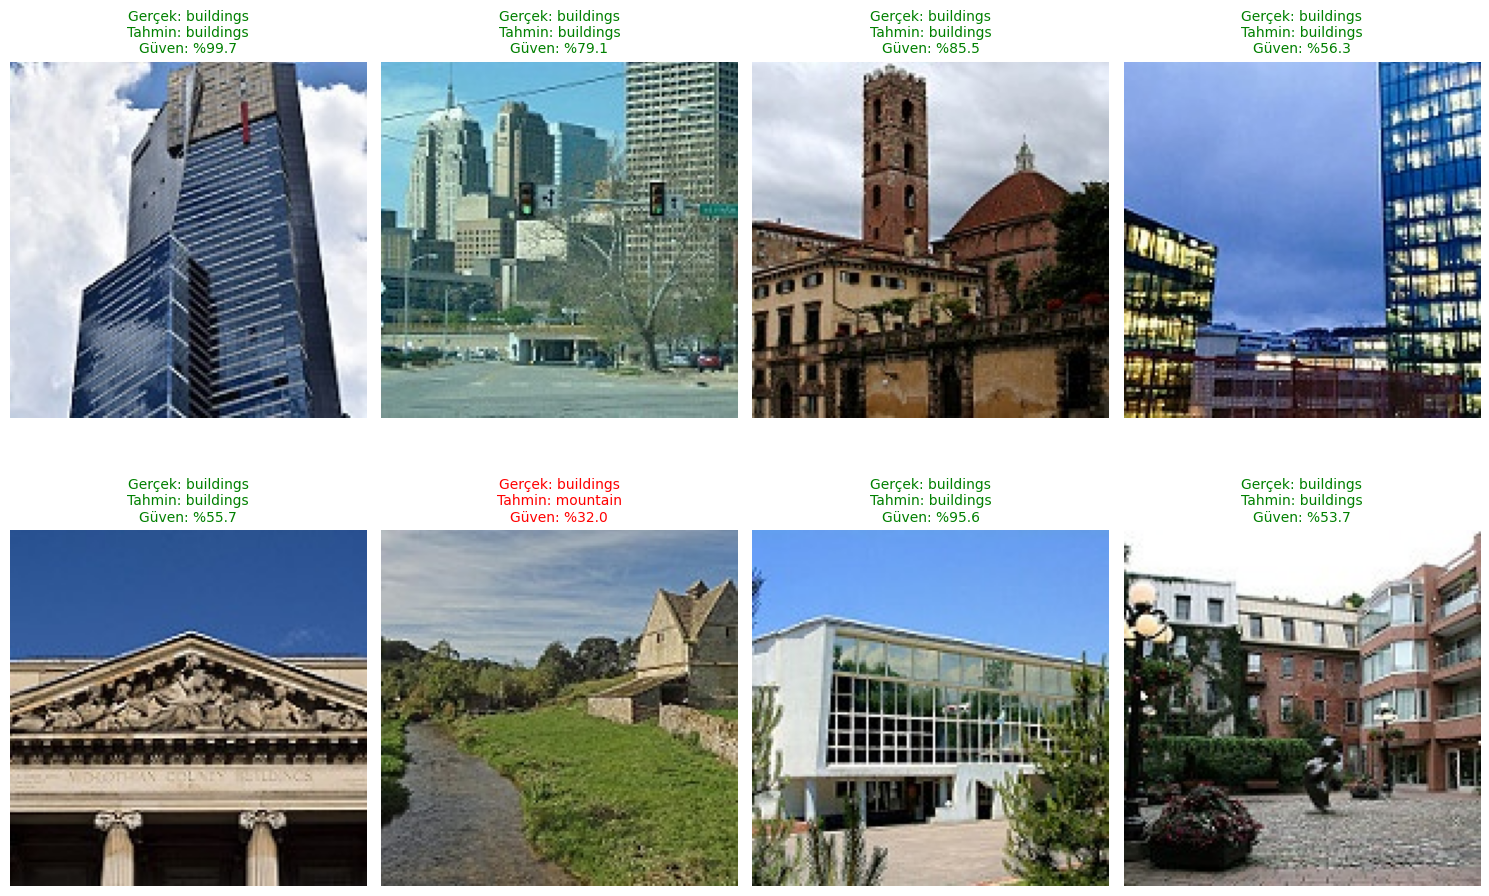

Tahmin Testi Sonu√ßlarƒ±:
Toplam tahmin: 32
Doƒüru tahmin: 25
Yanlƒ±≈ü tahmin: 7
Doƒüruluk: %78.12


In [6]:

test_images, test_labels = next(test_generator)
class_names = list(test_generator.class_indices.keys())

print(f"Test batch boyutu: {len(test_images)}")

# 2. Modelden tahmin al
predictions = model.predict(test_images)

# Tahminleri kontrol et
print(f"Tahmin ≈üekli: {predictions.shape}")  


# 3. ƒ∞lk 8 tahmini g√∂rselle≈ütir
plt.figure(figsize=(15, 10))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_images[i])
    
# Ger√ßek ve tahmin edilen sƒ±nƒ±flar
    true_class_idx = np.argmax(test_labels[i])
    pred_class_idx = np.argmax(predictions[i])
    
    true_class = class_names[true_class_idx]
    pred_class = class_names[pred_class_idx]
    confidence = np.max(predictions[i]) * 100  
    
    color = 'green' if true_class == pred_class else 'red'
    
    plt.title(f'Ger√ßek: {true_class}\nTahmin: {pred_class}\nG√ºven: %{confidence:.1f}', 
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

correct_predictions = 0
total_predictions = len(test_images)

for i in range(total_predictions):
    true_class_idx = np.argmax(test_labels[i])
    pred_class_idx = np.argmax(predictions[i])
    if true_class_idx == pred_class_idx:
        correct_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100

print("Tahmin Testi Sonu√ßlarƒ±:")
print(f"Toplam tahmin: {total_predictions}")
print(f"Doƒüru tahmin: {correct_predictions}")
print(f"Yanlƒ±≈ü tahmin: {total_predictions - correct_predictions}")
print(f"Doƒüruluk: %{accuracy:.2f}")



* A≈üaƒüƒ±daki kod satƒ±rƒ±nda "Confusion Matrix" kullanƒ±larak hangi sƒ±nƒ±flarƒ±n birbiriyle karƒ±≈ütƒ±rƒ±ldƒ±ƒüƒ± tespit edilmi≈ütir.


 Model Deƒüerlendirme:
Test Doƒüruluƒüu: %78.60
Confusion Matrix:
94/94 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 46ms/step


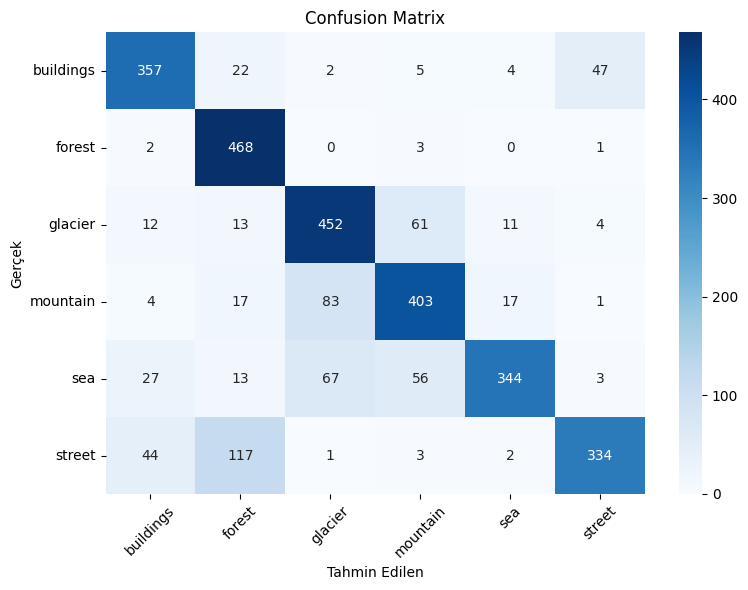

PERFORMANS √ñZETƒ∞
üìå buildings: 357/437 (%81.7)
üìå forest: 468/474 (%98.7)
üìå glacier: 452/553 (%81.7)
üìå mountain: 403/525 (%76.8)
üìå sea: 344/510 (%67.5)
üìå street: 334/501 (%66.7)
En ƒ∞yi Sƒ±nƒ±f: forest (%98.7)
En Zor Sƒ±nƒ±f: street (%66.7)
Genel Doƒüruluk: %78.60


In [7]:
print(" Model Deƒüerlendirme:")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Doƒüruluƒüu: %{test_accuracy*100:.2f}")

print("Confusion Matrix:")


# Tahminleri yapalƒ±m.

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion matrix olu≈ütur

cm = confusion_matrix(y_true, y_pred_classes)

# G√∂rselle≈ütir

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Ger√ßek')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. PERFORMANS √ñZETƒ∞

print("PERFORMANS √ñZETƒ∞")
print("=" * 40)

# Her sƒ±nƒ±fƒ±n doƒüruluk oranƒ±

class_accuracies = []
for i in range(len(class_names)):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0
    class_accuracies.append(accuracy)
    print(f"üìå {class_names[i]}: {correct}/{total} (%{accuracy*100:.1f})")

# En iyi ve en k√∂t√º sƒ±nƒ±f

best_class_idx = np.argmax(class_accuracies)
worst_class_idx = np.argmin(class_accuracies)

print(f"En ƒ∞yi Sƒ±nƒ±f: {class_names[best_class_idx]} (%{class_accuracies[best_class_idx]*100:.1f})")
print(f"En Zor Sƒ±nƒ±f: {class_names[worst_class_idx]} (%{class_accuracies[worst_class_idx]*100:.1f})")
print(f"Genel Doƒüruluk: %{test_accuracy*100:.2f}")

# 5) Hiperparametre Optimizasyonu 

 * Katman sayƒ±sƒ±nƒ± ,1 katman arttƒ±ralƒ±m .Daha derin bir √∂ƒürenme yapabilir.
 * Learning rate (√∂ƒürenme oranƒ±nƒ± )deƒüi≈ütirelim.Daha k√º√ß√ºk √∂ƒürenme oranƒ±yla model daha iyi √∂ƒürenecektir.

 


Epoch 1/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 91s 239ms/step - accuracy: 0.3591 - loss: 1.5522 - val_accuracy: 0.6113 - val_loss: 1.1812
Epoch 2/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 230ms/step - accuracy: 0.5975 - loss: 1.0475 - val_accuracy: 0.6213 - val_loss: 1.0304
Epoch 3/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 231ms/step - accuracy: 0.6435 - loss: 0.9203 - val_accuracy: 0.6887 - val_loss: 0.8200
Epoch 4/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 229ms/step - accuracy: 0.6973 - loss: 0.8123 - val_accuracy: 0.7336 - val_loss: 0.7192
Epoch 5/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 235ms/step - accuracy: 0.7319 - loss: 0.7369 - val_accuracy: 0.7143 - val_loss: 0.7358
Epoch 6/10
351/351 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 227ms/step - accuracy: 0.7531 - loss: 0.6734 - val_accuracy: 

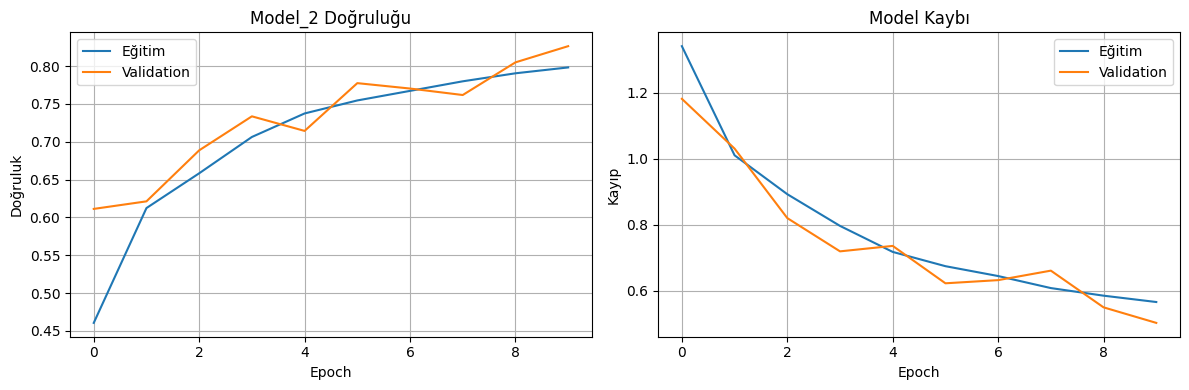

In [8]:
model_2 = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
#Eklenen Evri≈üim katmanƒ±
        
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.5),   
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model_2.compile(optimizer= Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)
plt.figure(figsize=(12, 4))  
plt.subplot(1, 2, 1)  
plt.plot(history_2.history['accuracy'], label='Eƒüitim') 
plt.plot(history_2.history['val_accuracy'], label='Validation') 
plt.title('Model_2 Doƒüruluƒüu') 
plt.xlabel('Epoch')  
plt.ylabel('Doƒüruluk')  
plt.legend()  
plt.grid(True) 
plt.subplot(1, 2, 2)  
plt.plot(history_2.history['loss'], label='Eƒüitim') 
plt.plot(history_2.history['val_loss'], label='Validation')  
plt.title('Model Kaybƒ±') 
plt.xlabel('Epoch') 
plt.ylabel('Kayƒ±p') 
plt.legend()  
plt.grid(True) 
plt.tight_layout()  
plt.show()  

* Optimizasyon sonucunda ; Eƒüitim ile validation doƒürularƒ± birbirine  yakƒ±nla≈ümƒ±≈ütƒ±r ve validation genel manada artƒ±≈ü g√∂stermi≈ütir.Bu da modelin √∂ƒürenmesinde,genellemesinde iyile≈üme saƒülandƒ±ƒüƒ±nƒ± g√∂sterir.
* Modelde,validation doƒürusunun hep eƒüitim doƒürusunun √ºzerinde olmasƒ± modelin a≈üƒ±rƒ± √∂ƒürenme durumunda olmadƒ±ƒüƒ±nƒ± g√∂stermi≈ütir.
* Loss deƒüerinde g√ºzel bir d√º≈ü√º≈ü ya≈üanmƒ±≈ütƒ±r.
* Model doƒüruluƒüu ise artƒ±≈ü g√∂stermi≈ütir. 

## Modellerin Kar≈üƒ±la≈ütƒ±rƒ±lmasƒ± :

Hiperparemetre Optimizasyonu kapsamƒ±nda:
* √∂ƒürenme oranƒ±ndaki artƒ±≈ü (0.001 den 0.0005 e y√ºkseli≈ü)
* Katman sayƒ±sƒ±nƒ± arttƒ±rmak (3 den 4 e arttƒ±rma)
sayesinde model doƒüruluƒüu artƒ±≈ü g√∂stermi≈ütir.

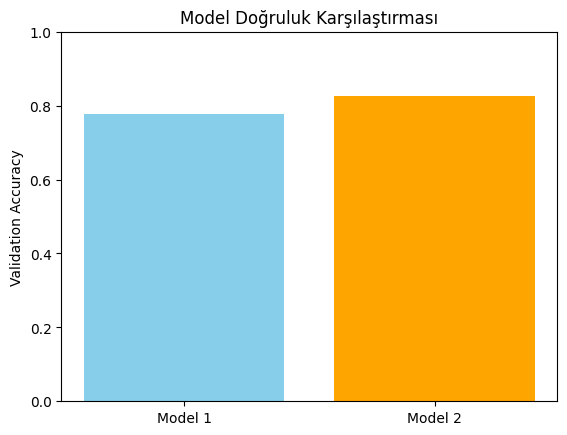

In [9]:
import matplotlib.pyplot as plt

# Doƒüru tanƒ±mlanmƒ±≈ü history objeleri √ºzerinden doƒüruluk skorlarƒ±nƒ± √ßek
acc_model1 = history.history['val_accuracy'][-1]
acc_model2 = history_2.history['val_accuracy'][-1]

# Bar grafiƒüi ile kar≈üƒ±la≈ütƒ±r
plt.bar(['Model 1', 'Model 2'], [acc_model1, acc_model2], color=['skyblue', 'orange'])
plt.ylabel('Validation Accuracy')
plt.title('Model Doƒüruluk Kar≈üƒ±la≈ütƒ±rmasƒ±')
plt.ylim(0, 1)
plt.show()


In [10]:
print(" Model 1  Deƒüerlendirme:")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Doƒüruluƒüu: %{test_accuracy*100:.2f}")

print(" Model 2  Deƒüerlendirme:")
test_loss, test_accuracy = model_2.evaluate(test_generator, verbose=0)
print(f"Test Doƒüruluƒüu: %{test_accuracy*100:.2f}")

 Model 1  Deƒüerlendirme:
Test Doƒüruluƒüu: %78.60
 Model 2  Deƒüerlendirme:
Test Doƒüruluƒüu: %84.87
